The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


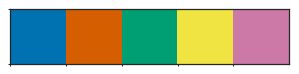

In [131]:
import os
from glob import glob
from collections import Counter
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

import pandas as pd
import rpy2.robjects as robj

import pysam

%load_ext rpy2.ipython
robj.pandas2ri.activate()

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [140]:
%%bash
source activate ml_python35
python novel_splice_junct_counts.py \
  -a ~/Documents/genomes/tair10/gff/araport_flat_genes.bed \
  -b `ls ~/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/*.sorted.bam | paste -s -d","` \
> novel_splice_junction_counts_unique_mapping_only.tsv

Traceback (most recent call last):
  File "novel_splice_junct_counts.py", line 132, in <module>
    count_novel_splice_juncs()
  File "/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/click/core.py", line 722, in __call__
    return self.main(*args, **kwargs)
  File "/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/click/core.py", line 697, in main
    rv = self.invoke(ctx)
  File "/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/click/core.py", line 895, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/click/core.py", line 535, in invoke
    return callback(*args, **kwargs)
  File "novel_splice_junct_counts.py", line 118, in count_novel_splice_juncs
    splice_juncs = [fetch_splice_juncs(bam, *inv) for bam in alignment_files]
  File "novel_splice_junct_counts.py", line 118, in <listcomp>
    splice_juncs = [fetch_splice_juncs(bam, *inv) f

In [141]:
!head novel_splice_junction_counts_unique_mapping_only.tsv

gene_id	chrom	start	end	strand	sj_class	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/A_Negative.sorted.bam	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/A_NMM.sorted.bam	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/B_Negative.sorted.bam	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/B_NMM.sorted.bam	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/C_Negative.sorted.bam	/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/C_NMM.sorted.bam
AT1G01010	1	5095	5173	+	constitutive	1163	710	1235	987	972	517
AT1G01010	1	4276	4505	+	alternate	13	6	10	10	8	4
AT1G01010	1	5326	5438	+	constitutive	824	566	843	777	741	398
AT1G01010	1	4605	4705	+	constitutive	641	363	661	546	623	327
AT1G01010	1	3913	3995	+	constitutive	738	302	706	467	544	300
AT1G01010	1	4276	4485	+	constitutive	774	405	806	572	696	361
AT1G01020	1	7069	7156	-	constitutive	458	597	490	726	433	329
AT1G01020	1	8296	8416	-	

In [27]:
splice_junction_counts = pd.read_table(
    './novel_splice_junction_counts_unique_mapping_only.tsv',
    sep='\t',
    names=['gene_id', 'chrom', 'start', 'end', 'strand', 'sj_class',
           'neg_1', 'nmm_1', 'neg_2', 'nmm_2', 'neg_3', 'nmm_3'],
    header=0
)
splice_junction_counts.head()

,gene_id,chrom,start,end,strand,sj_class,neg_1,nmm_1,neg_2,nmm_2,neg_3,nmm_3
0,AT1G01010,1,5095,5173,+,constitutive,1172,716,1245,991,988,519
1,AT1G01010,1,4276,4505,+,alternate,13,6,11,10,8,4
2,AT1G01010,1,5326,5438,+,constitutive,838,574,848,789,749,410
3,AT1G01010,1,4605,4705,+,constitutive,645,363,661,548,625,327
4,AT1G01010,1,3913,3995,+,constitutive,739,302,706,467,544,300


In [32]:
%%R -i splice_junction_counts
library(GenomicRanges)
library(limma)
library(edgeR)

sample_groups <- factor(rep(c('nmm', 'neg'), 3))
sample_ids <- paste(sample_groups, rep(1:3, each=2), sep='_')
design <- model.matrix(~0 + sample_groups)
rownames(design) <- sample_ids
colnames(design) <- levels(sample_groups)
contrasts <- makeContrasts(nmm - neg, levels=design)

gene_ids <- as.character(splice_junction_counts$gene_id)
strands <- splice_junction_counts$strand

# produce unique exon ids for each exon chunk
number_junctions_sequentially <- function(n_exons, strand) {
    exon_numbers <- seq_len(n_exons)
    if (strand == '-') {
        exon_numbers <- rev(exon_numbers)
    }
    return (exon_numbers)
}
junc_numbers <- mapply(number_junctions_sequentially,
                       n_exons=rle(gene_ids)$length,
                       strand=strands[!duplicated(gene_ids)])
junc_numbers <- unlist(junc_numbers)
junc_ids <- paste(gene_ids, junc_numbers, sep='.j')

# interval info for each exon
genomic_range <- splice_junction_counts[, c('chrom', 'start', 'end', 'strand')]
genomic_range['junc_id'] <- junc_ids

splice_junction_counts <- as.matrix(
    splice_junction_counts[, 7:ncol(splice_junction_counts)])
rownames(splice_junction_counts) <- junc_ids
colnames(splice_junction_counts) <- sample_ids
head(splice_junction_counts)

             nmm_1 neg_1 nmm_2 neg_2 nmm_3 neg_3
AT1G01010.j1  1172   716  1245   991   988   519
AT1G01010.j2    13     6    11    10     8     4
AT1G01010.j3   838   574   848   789   749   410
AT1G01010.j4   645   363   661   548   625   327
AT1G01010.j5   739   302   706   467   544   300
AT1G01010.j6   776   405   806   572   697   361


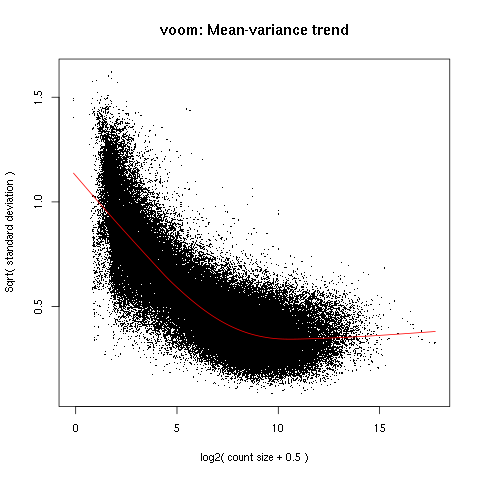

In [35]:
%%R
dge <- DGEList(counts=splice_junction_counts)
dge <- calcNormFactors(dge)
v <- voom(dge, design, plot=TRUE)

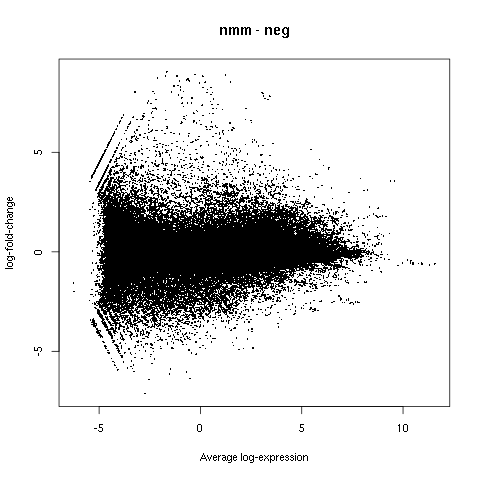

In [36]:
%%R
fit <- lmFit(v, design)
fit <- eBayes(fit)
cfit <- contrasts.fit(fit, contrasts)
cfit <- eBayes(cfit)
limma::plotMA(cfit)

In [38]:
%%R -o splice_res,norm_counts
ds <- diffSplice(cfit, gene_ids, exonid=rownames(counts), verbose=TRUE)
norm_counts <- as.data.frame(cpm(dge, normalized.lib.sizes = TRUE, log=TRUE))
splice_res <- topSplice(ds, test='t', n=Inf, sort.by="none")

Total number of exons:  130482 
Total number of genes:  18008 
Number of genes with 1 exon:  2479 
Mean number of exons in a gene:  7 
Max number of exons in a gene:  518 


In [192]:
diff_splice[(diff_splice.sj_class == 'Alternate') & (diff_splice.strand == '+')].sort_values('avg_express', ascending=False).head()

,gene_id,chrom,start,end,strand,sj_class,neg_1_raw,nmm_1_raw,neg_2_raw,nmm_2_raw,...,logFC,P.Value,FDR,nmm_1_logCPM,neg_1_logCPM,nmm_2_logCPM,neg_2_logCPM,nmm_3_logCPM,neg_3_logCPM,avg_express
14451,AT1G26630,1,9206891,9206993,+,Alternate,21468,26801,21713,38471,...,-0.178451,0.391548,0.999976,8.365945,8.459003,8.235918,8.524750,8.426294,8.494391,8.417717
74556,AT3G52300,3,19397716,19397819,+,Alternate,12441,15691,12598,21739,...,0.090894,0.884747,0.999976,7.578870,7.686663,7.450565,7.701274,7.385317,7.701398,7.584015
7841,AT1G14320,1,4888279,4888548,+,Alternate,14455,16118,12458,19712,...,-0.185305,0.212961,0.999976,7.795333,7.725398,7.434443,7.560065,7.584729,7.349315,7.574881
83187,AT4G05320,4,2718254,2718558,+,Alternate,15851,8422,18023,15293,...,-0.197393,0.481579,0.999976,7.928336,6.788981,7.967201,7.193870,8.015245,7.552746,7.574397
44212,AT2G27720,2,11818783,11819021,+,Alternate,12252,9825,7985,16026,...,-0.090552,0.624089,0.999976,7.556785,7.011270,6.792751,7.261411,7.318791,7.015805,7.159469


In [146]:
norm_counts = norm_counts.reset_index(drop=True)
diff_splice = (splice_junction_counts.join(splice_res[['logFC', 'P.Value', 'FDR']])
                                     .join(norm_counts, lsuffix='_raw', rsuffix='_logCPM'))
diff_splice['avg_express'] = norm_counts.mean(1)
diff_splice['sj_class'] = diff_splice.sj_class.str.replace('/', '/\n').str.capitalize()
diff_splice.sort_values('FDR').head()

,gene_id,chrom,start,end,strand,sj_class,neg_1_raw,nmm_1_raw,neg_2_raw,nmm_2_raw,...,logFC,P.Value,FDR,nmm_1_logCPM,neg_1_logCPM,nmm_2_logCPM,neg_2_logCPM,nmm_3_logCPM,neg_3_logCPM,avg_express
29432,AT1G69840,1,26295187,26295702,-,Retained/\nexitronic,13,6,10,9,...,-2.863792,2.343283e-19,2.999472e-14,-2.298959,-3.604533,-2.813219,-3.480477,-2.986315,-3.695272,-3.146463
55384,AT3G01650,3,243751,243859,+,Constitutive,849,384,960,472,...,-1.662428,7.550279e-18,4.832292e-13,3.706030,2.334934,3.736892,2.176991,3.636086,2.374509,2.994240
55389,AT3G01650,3,243338,243412,+,Constitutive,717,286,710,346,...,2.193048,2.743050e-17,1.170396e-12,3.462308,1.910179,3.301807,1.729374,3.278200,1.832975,2.585807
85301,AT4G12720,4,7487752,7487825,+,Retained/\nexitronic,16,10,23,9,...,-2.539403,3.728433e-16,1.193127e-11,-2.003975,-2.891860,-1.631388,-3.480477,-2.986315,-4.632526,-2.937757
55325,AT3G01540,3,216153,216241,-,Alternate,12,0,9,2,...,3.919201,6.106351e-14,1.563263e-09,-2.412408,-8.186874,-2.961360,-5.468904,-4.337402,-8.186874,-5.258971


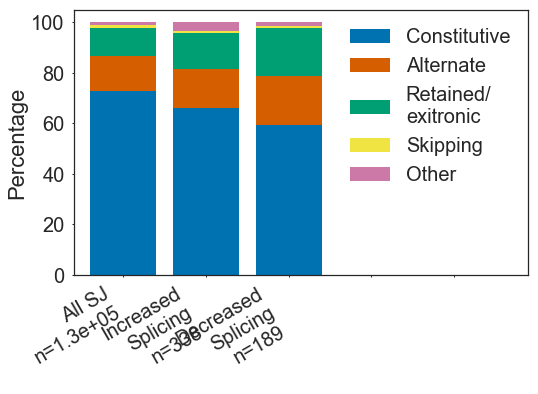

In [183]:
def stacked_percentage_bars(groups, labels, order, width, colors, **subplot_kws):
    fig, ax = plt.subplots(**subplot_kws)
    for x, categorical in enumerate(groups, 1):
        counts = Counter(categorical)
        counts = [counts[c] for c in order]
        cum_counts = np.cumsum(counts) / sum(counts) * 100
        ax.bar(np.repeat(x - (width / 2), len(cum_counts)),
               height=cum_counts[::-1],
               width=width,
               color=colors[::-1])
    ax.set_xticks(np.arange(1, len(categorical) + 1) - (width / 2))
    ax.set_xticklabels(['{}\nn={:.3g}'.format(lab, len(g)) for lab, g in zip(labels, groups)],
                       rotation=30, ha='right')
    ax.set_ylabel('Percentage')
    ax.set_xlim(0, len(groups) + 1 - width)
    dummy_patches = []
    for label, color in zip(order, colors):
        dummy_patches.append(
            Patch(facecolor=color, label=label)
        )
    ax.legend(handles=dummy_patches, loc='upper right')
    plt.tight_layout()
    return fig, ax
        

fig, ax = stacked_percentage_bars(
    groups=[diff_splice.sj_class.values,
            diff_splice[(diff_splice.logFC > 0.5) & (diff_splice.FDR < 0.2)].sj_class.values,
            diff_splice[(diff_splice.logFC < -0.5) & (diff_splice.FDR < 0.2)].sj_class.values],
    labels=['All SJ', 'Increased\nSplicing', 'Decreased\nSplicing'],
    order=['Constitutive', 'Alternate', 'Retained/\nexitronic', 'Skipping', 'Other'],
    width=0.8, colors=pal[:5],
    figsize=(8, 6)
)
ax.set_xlim(0, 5.5)
plt.savefig('./intron_class_proportion.svg')
plt.show()

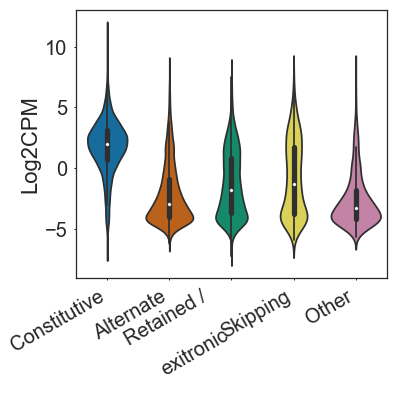

In [165]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(
    x='sj_class',
    y='avg_express',
    data=diff_splice,
    order=['Constitutive', 'Alternate',
           'Retained/\nexitronic', 'Skipping', 'Other'],
    ax=ax
)
ax.set_xticklabels([x.get_text().replace('/', ' /\n').capitalize()
                    for x in ax.get_xticklabels()],
                   rotation=30,
                   ha='right')
ax.set_ylabel('Log2CPM')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('./intron_class_expression.svg')
plt.show()

In [2]:
ext_table = pd.read_csv('../extensin_showalter_table/ext_table.csv')
ext_table.head()

,AGI Identifier,gene_symbol,class,expression_tissue,sp3_motif,sp4_motif,sp5_motif,yxy_motif,chrom,start,end,strand,gene_length,overlapping_pg4,filtered_pg4,merged_pg4,logFC,logCPM,FDR
0,AT1G26240,EXT20,SP5,Roots,2,1,40,44,1,9077873,9079646,-,1773,440,102,44,3.721471,6.802750,1.096868e-168
1,AT1G26250,EXT21,SP5,Roots,7,0,28,40,1,9083837,9085464,+,1627,480,92,38,-3.403088,5.565503,5.061161e-10
2,AT4G08370,EXT22,SP5,NaN,3,1,13,18,4,5301961,5303314,-,1353,441,70,25,NaN,NaN,NaN
3,AT4G13390,EXT18,SP5/SP4,Roots,0,14,8,13,4,7783790,7785366,+,1576,634,68,31,-2.627889,5.474627,8.447693e-28
4,AT5G19810,EXT19,SP5/SP4,Roots,0,4,13,1,5,6692908,6694058,+,1150,466,70,21,NaN,NaN,NaN


In [3]:
ext_genes = set(ext_table['AGI Identifier'].values)

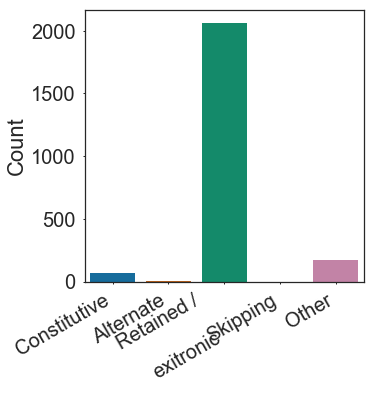

In [211]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(
    diff_splice[diff_splice.gene_id.isin(ext_genes)].sj_class,
    order=['Constitutive', 'Alternate', 'Retained/\nexitronic', 'Skipping', 'Other']
)
ax.set_xticklabels([x.get_text().replace('/', ' /\n').capitalize()
                    for x in ax.get_xticklabels()],
                   rotation=30,
                   ha='right')
ax.set_ylabel('Count')
ax.set_xlabel('')
plt.savefig('./extensin_family_intron_classes.svg')
plt.show()

In [144]:
BED_CONVERTERS = {
    'chrom': str,
    'start': int,
    'end': int,
    'gene_id': str,
    'is_reverse': lambda x: x == '-',
    'exon_sizes': partial(np.fromstring, sep=',', dtype='i8'),
    'exon_starts': partial(np.fromstring, sep=',', dtype='i8')
}

def load_bed(bed_fn):
    bed = pd.read_table(
        bed_fn,
        sep='\t',
        names=['chrom', 'start', 'end', 'gene_id', '_', 'is_reverse',
               '_', '_', '_', '_', 'exon_sizes', 'exon_starts'],
        converters=BED_CONVERTERS,
        usecols=[0, 1, 2, 3, 5, 10, 11],
        index_col='gene_id'
    )
    bed['exon_starts'] = bed['exon_starts'] + bed['start']
    bed['exon_ends'] = bed['exon_starts'] + bed['exon_sizes']
    return bed.drop('exon_sizes', axis=1)


def check_orientation(aln, gene_reverse):
    # correct for reversely stranded libraries
    if gene_reverse ^ bool(aln.is_reverse):
        return bool(aln.is_read1)
    else:
        return bool(aln.is_read2)


def extract_sj_from_aln(aln, start, end):
    leftmost = aln.reference_start
    curr_pos = 0
    splice_juncts = []
    for i, (cig_type, n_bases) in enumerate(aln.cigar):
        if cig_type in (0, 2):
            curr_pos += n_bases
        elif cig_type == 3:
            if aln.reference_start > start and aln.reference_end < end:
                splice_juncts.append((leftmost + curr_pos,
                                      leftmost + curr_pos + n_bases))
            curr_pos += n_bases
    return splice_juncts


def assign_splice_junc_classes(splice_juncs, exon_starts, exon_ends):
    sj_classes = {}
    for sj_start, sj_end in splice_juncs:
        donor_canon = sj_start in exon_ends
        acceptor_canon = sj_end in exon_starts
        # check if normal donor/acceptor
        if donor_canon and acceptor_canon:
            # check if exon skipping
            if np.any((exon_starts > sj_start) & (exon_ends < sj_end)):
                sj_classes[(sj_start, sj_end)] = 'skipping'
            else:
                sj_classes[(sj_start, sj_end)] = 'constitutive'
        elif donor_canon or acceptor_canon:
            # different donor or acceptor site
            sj_classes[(sj_start, sj_end)] = 'alternate'
        else:
            # check if contained within exon
            if np.any((exon_starts < sj_start) & (exon_ends > sj_end)):
                sj_classes[(sj_start, sj_end)] = 'retained/exitronic'
            else:
                sj_classes[(sj_start, sj_end)] = 'other'
    return sj_classes


def count_splice_juncs(bam, chrom, start, end,
                       gene_reverse,
                       exon_starts, exon_ends):
    aligned_reads = bam.fetch(chrom, start, end)
    junct_lengths = []
    tot_count = 0
    splice_juncts = []
    for aln in aligned_reads:
        if not aln.is_proper_pair or aln.mapping_quality != 255:
            continue
        if check_orientation(aln, gene_reverse):
            tot_count += 1
            if 'N' in aln.cigarstring:
                splice_juncts.append(extract_sj_from_aln(aln, start, end))
    unique_splice_juncts = set(sum(splice_juncts, []))
    unique_splice_juncts = assign_splice_junc_classes(
        unique_splice_juncts,
        exon_starts, exon_ends
    )
    exitron_filtered = [k for k, v in unique_splice_juncts.items()
                        if v == 'retained/exitronic']
    n_spliced = 0
    for spliced_read_junc_set in splice_juncts:
        counted=False
        for sj in spliced_read_junc_set:
            if sj in exitron_filtered:
                if not counted:
                    n_spliced += 1
                    counted=True
                junct_lengths.append(sj[1] - sj[0])
    return n_spliced, tot_count, junct_lengths

In [145]:
fn = glob('/home/matthew/sharc_fastdata'
          '/tair10_nmm_splicing/'
          'star_splice_junct/*.sorted.bam')
fn.sort()

bams = [pysam.AlignmentFile(b) for b in fn]
bed = load_bed('~/Documents/genomes/tair10/gff/araport_flat_genes.bed')
ext_invs = bed[bed.index.isin(ext_genes)]

In [147]:
extensin_exitron_percentages = {}
extensin_exitron_spliced_sizes = {}
for gene_id, *inv in ext_invs.itertuples():
    print(gene_id)
    spliced_count = []
    spliced_percentage = []
    total_mapped = []
    spliced_sizes = []
    for bam in bams:
        n_spliced, n_mapped, junct_lengths = count_splice_juncs(bam, *inv)
        spliced_count.append(n_spliced)
        spliced_percentage.append((n_spliced) / (n_mapped + 1) * 100)
        total_mapped.append(n_mapped)
        spliced_sizes.append(junct_lengths)
    extensin_exitron_percentages[gene_id] = (*spliced_percentage,
                                             *total_mapped,
                                             *spliced_count)
    extensin_exitron_spliced_sizes[gene_id] = spliced_sizes
extensin_exitron_percentages = pd.DataFrame.from_dict(
    extensin_exitron_percentages,
    orient='index',
)
samples = ['neg_1', 'nmm_1', 'neg_2', 'nmm_2', 'neg_3', 'nmm_3']
extensin_exitron_percentages.columns = [
    *['percentage_exitronic_{}'.format(x) for x in samples],
    *['total_mapped_{}'.format(x) for x in samples],
    *['total_exitronic_{}'.format(x) for x in samples]
]
extensin_exitron_percentages.head()

AT1G02405
AT1G10620
AT1G12040
AT1G21310
AT1G23040
AT1G23540
AT1G23720
AT1G26150
AT1G26240
AT1G26250
AT1G49270
AT1G49490
AT1G52290
AT1G54215
AT1G62440
AT1G62760
AT1G70460
AT1G70990
AT1G76930
AT2G15880
AT2G18470
AT2G24980
AT2G43150
AT3G06750
AT3G11030
AT3G18810
AT3G19020
AT3G19430
AT3G20850
AT3G22800
AT3G24480
AT3G24540
AT3G24550
AT3G28550
AT3G49270
AT3G50580
AT3G53330
AT3G54580
AT3G54590
AT4G08370
AT4G08380
AT4G08400
AT4G08410
AT4G11430
AT4G13340
AT4G13390
AT4G16140
AT4G18670
AT4G22470
AT4G32710
AT4G33970
AT4G34440
AT5G06630
AT5G06640
AT5G11990
AT5G19800
AT5G19810
AT5G25550
AT5G26080
AT5G35190
AT5G38560
AT5G49080
AT5G49280


,percentage_exitronic_neg_1,percentage_exitronic_nmm_1,percentage_exitronic_neg_2,percentage_exitronic_nmm_2,percentage_exitronic_neg_3,percentage_exitronic_nmm_3,total_mapped_neg_1,total_mapped_nmm_1,total_mapped_neg_2,total_mapped_nmm_2,total_mapped_neg_3,total_mapped_nmm_3,total_exitronic_neg_1,total_exitronic_nmm_1,total_exitronic_neg_2,total_exitronic_nmm_2,total_exitronic_neg_3,total_exitronic_nmm_3
AT3G53330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,0,0,0,0,0,0,0,0,0,0
AT3G24540,0.000000,0.000000,0.000000,0.000000,1.176471,0.000000,62,24,130,58,84,45,0,0,0,0,1,0
AT2G24980,11.615011,8.237232,10.788046,10.827169,11.532385,10.039932,10098,1820,12346,1486,10760,1752,1173,150,1332,161,1241,176
AT1G21310,4.342114,3.247758,4.137311,3.962727,4.357747,3.796426,478798,308304,725857,306278,439997,338844,20790,10013,30031,12137,19174,12864
AT5G19800,0.371058,0.000000,0.121803,0.000000,0.000000,0.000000,538,88,820,54,542,74,2,0,1,0,0,0


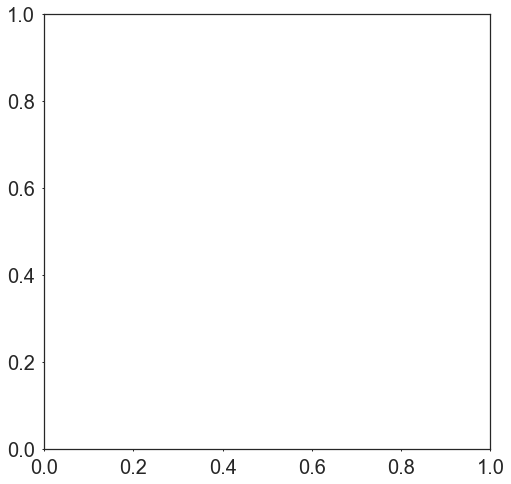

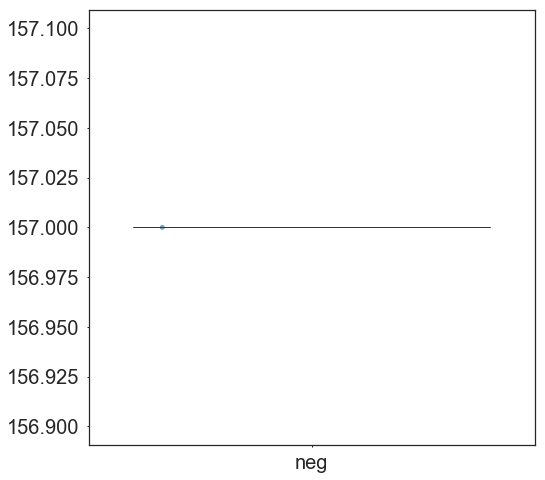

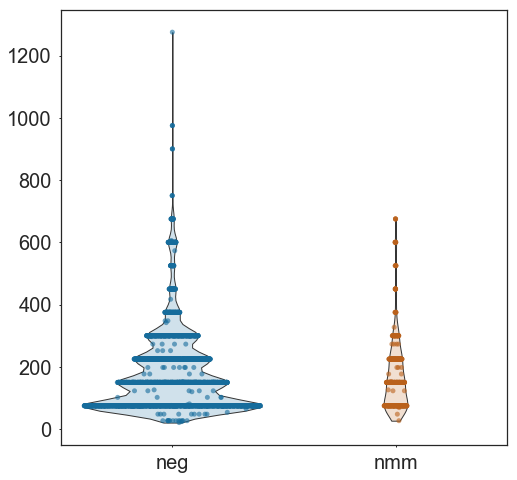

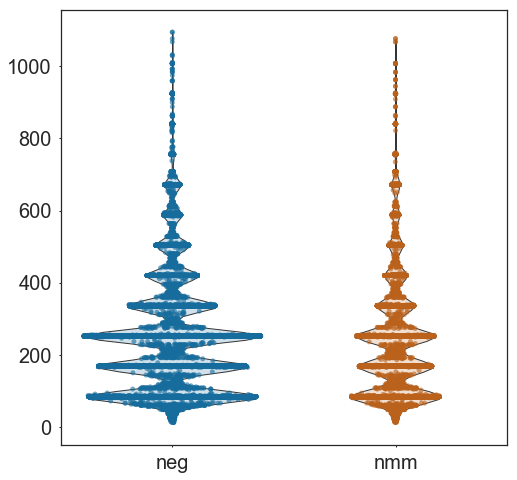

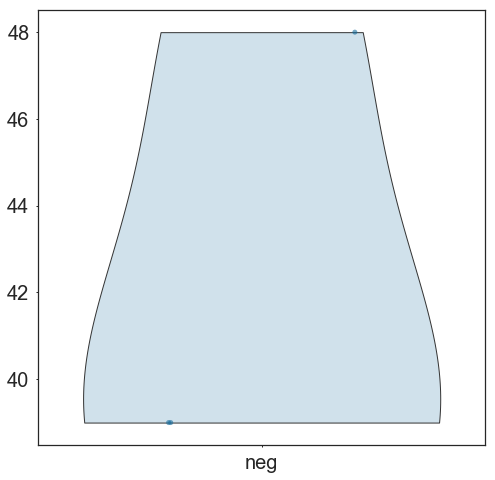

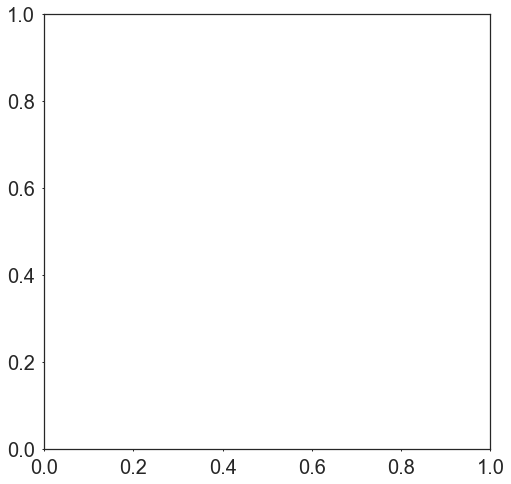

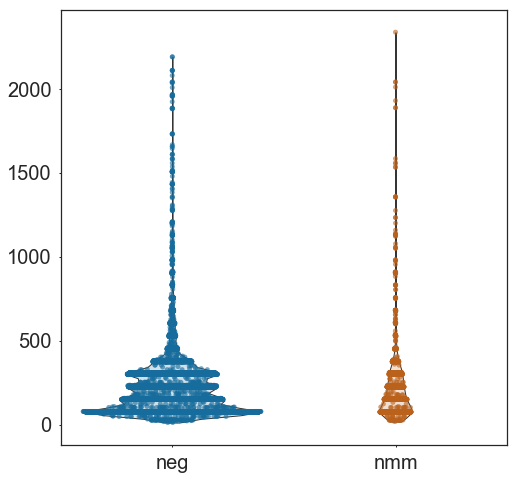

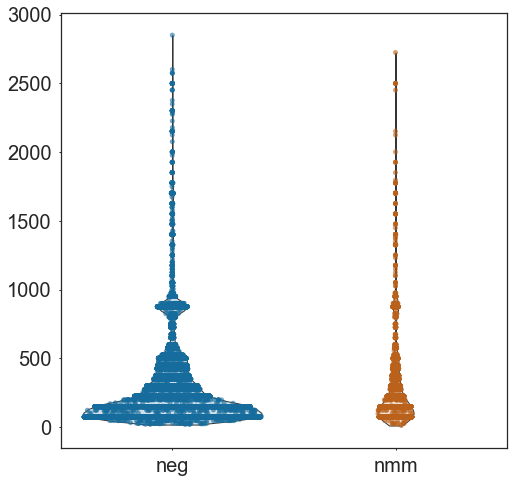

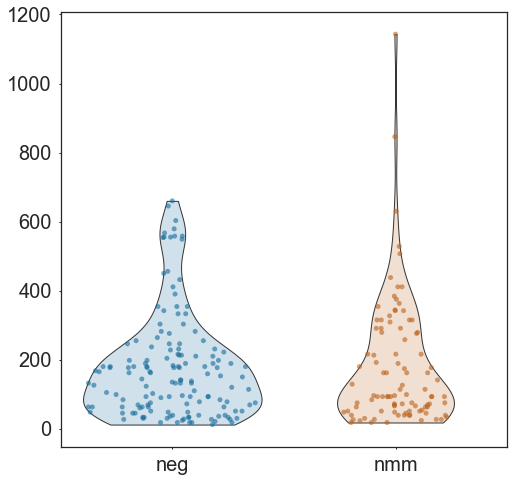

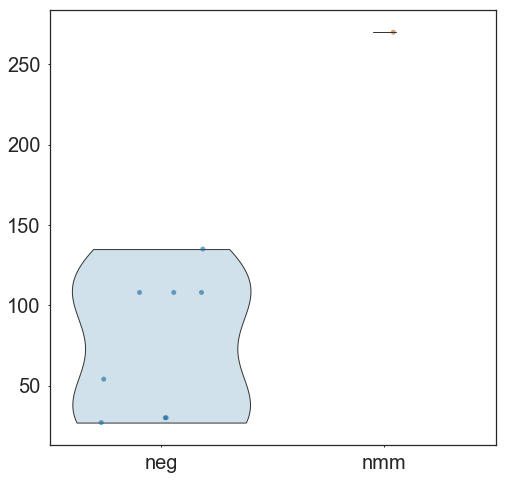

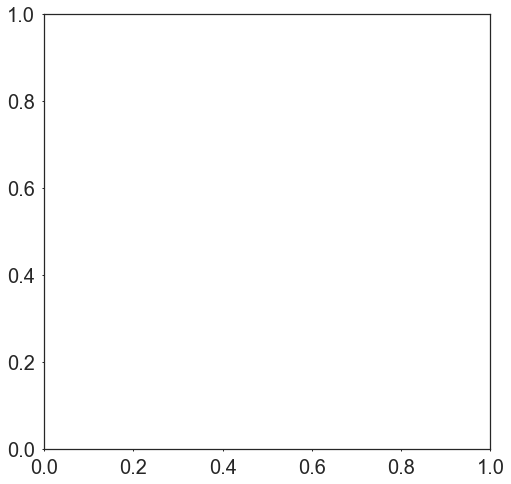

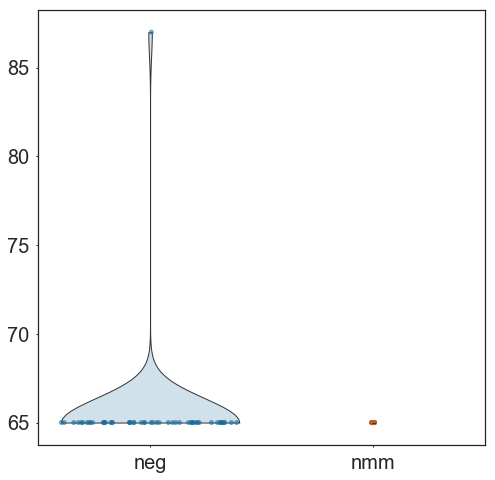

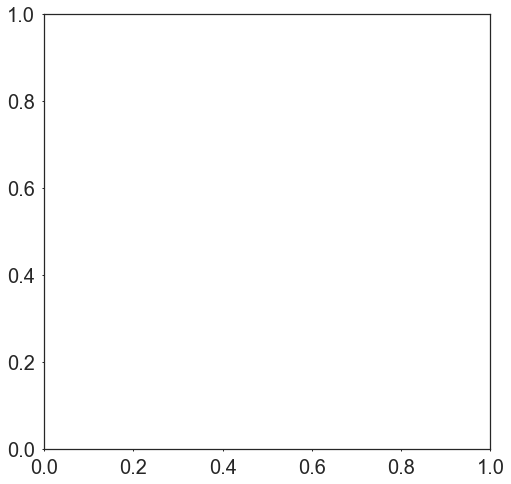

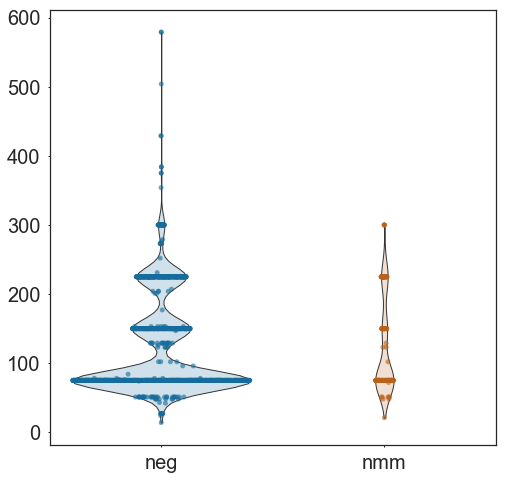

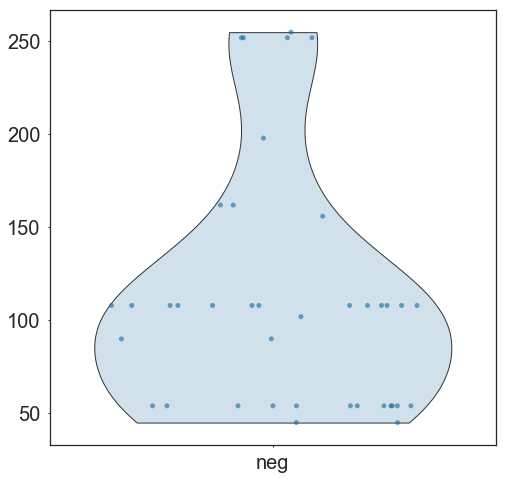

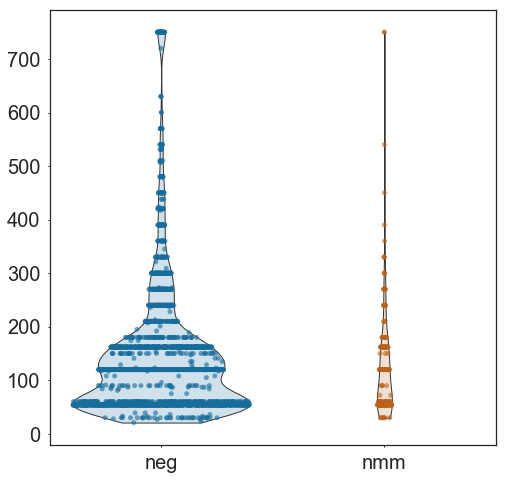

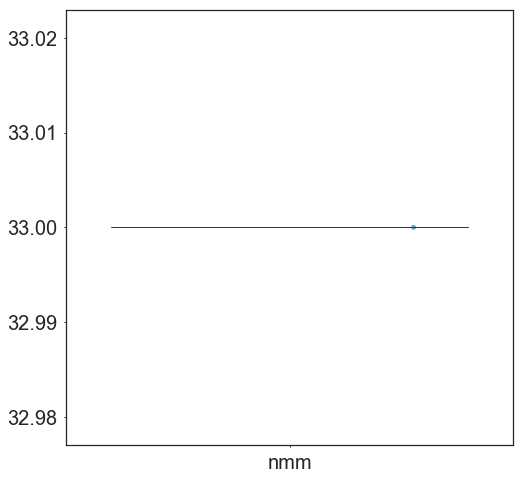

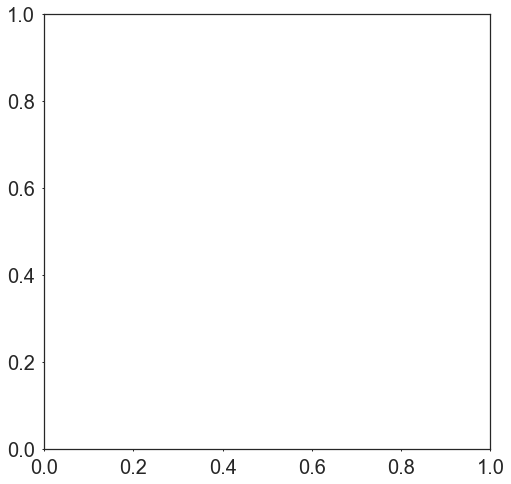

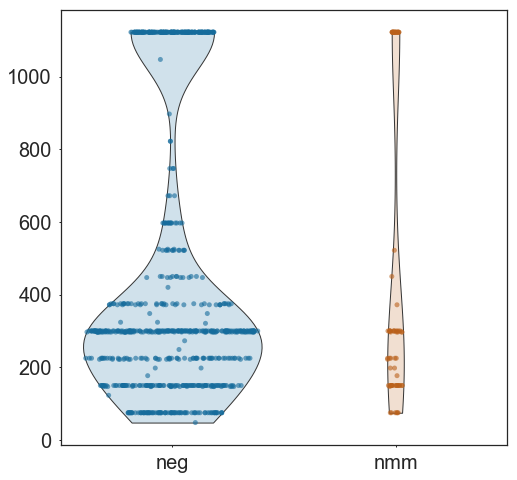

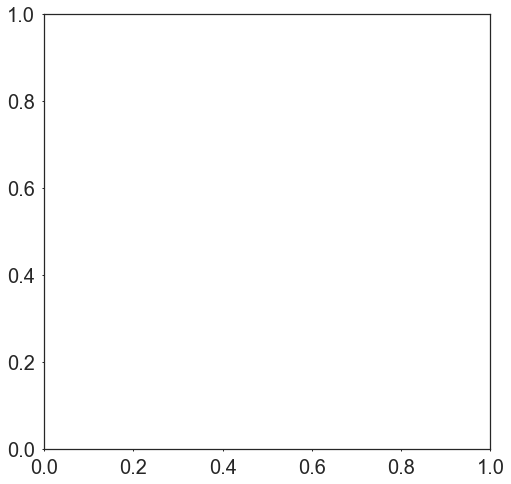

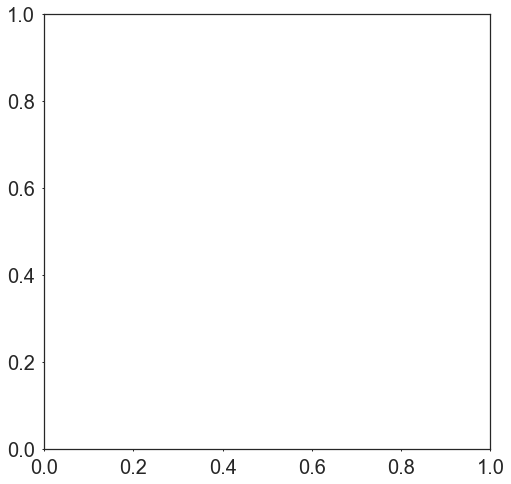

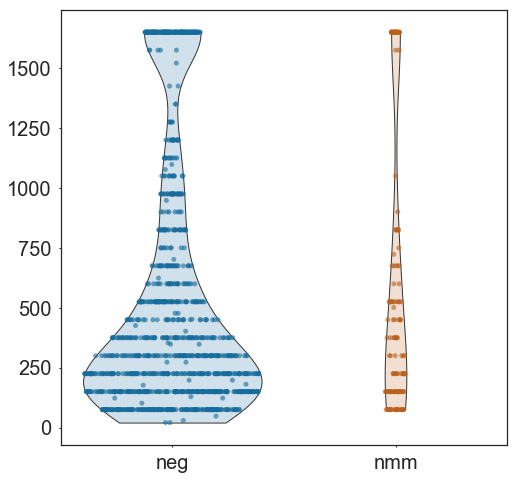

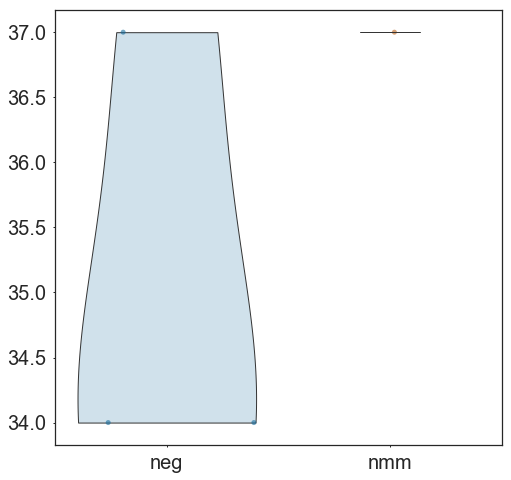

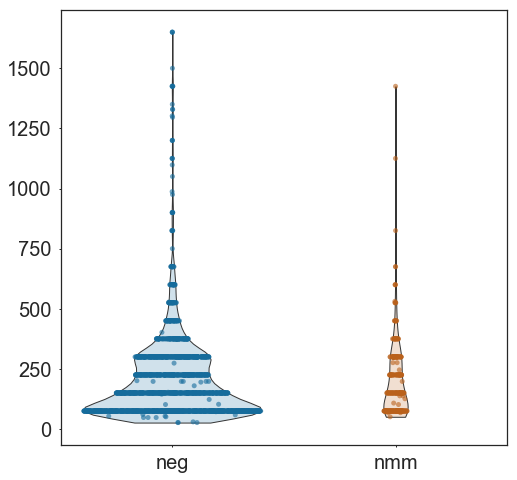

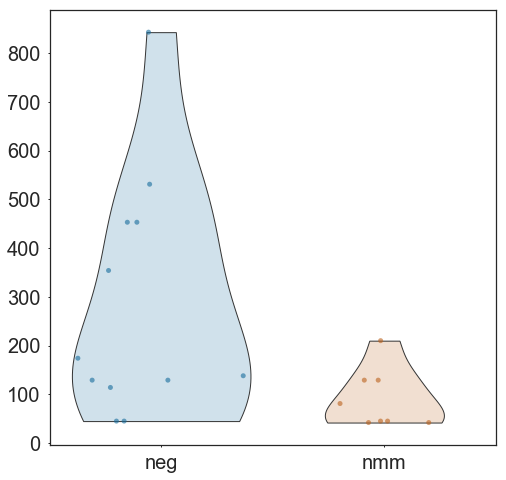

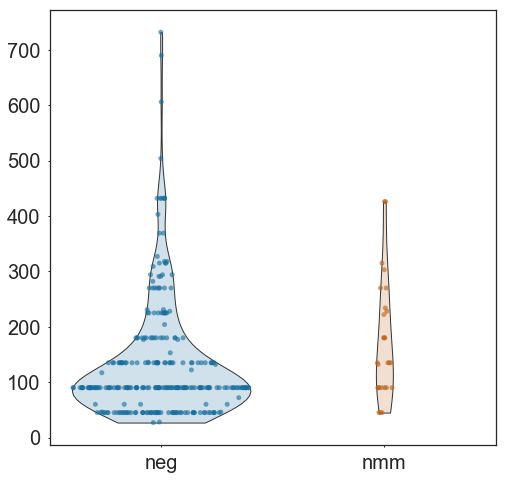

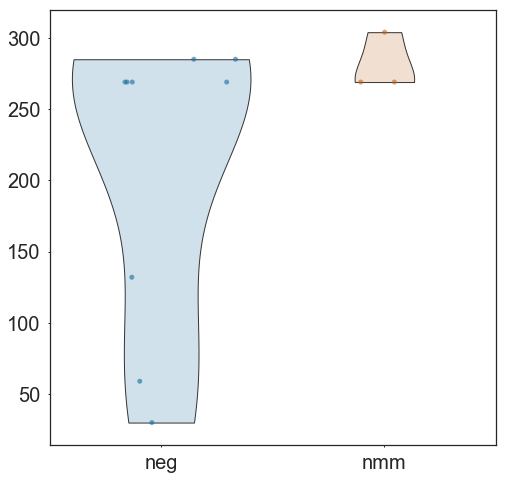

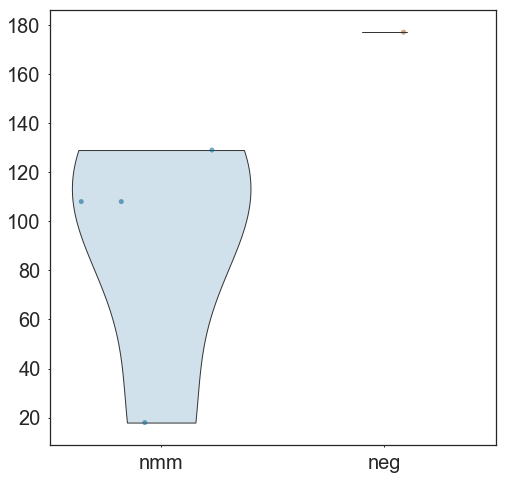

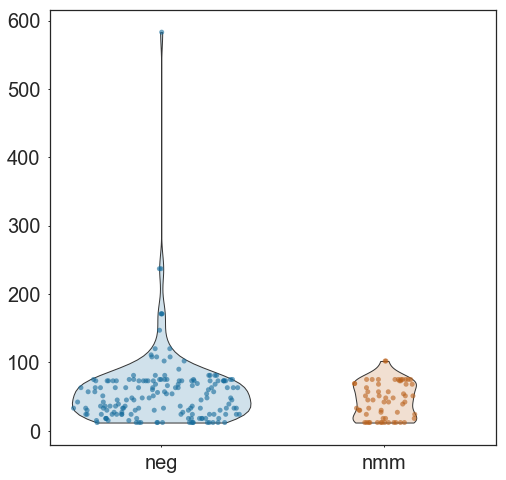

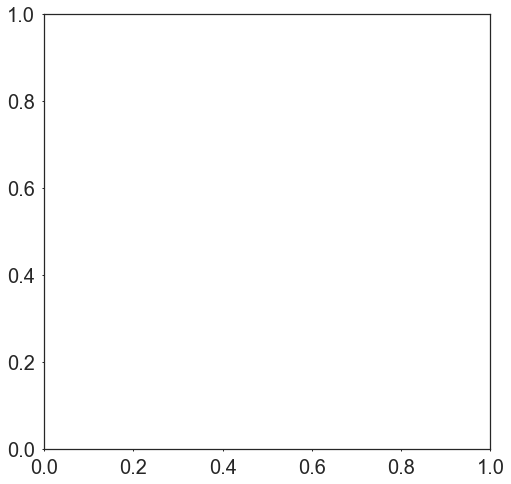

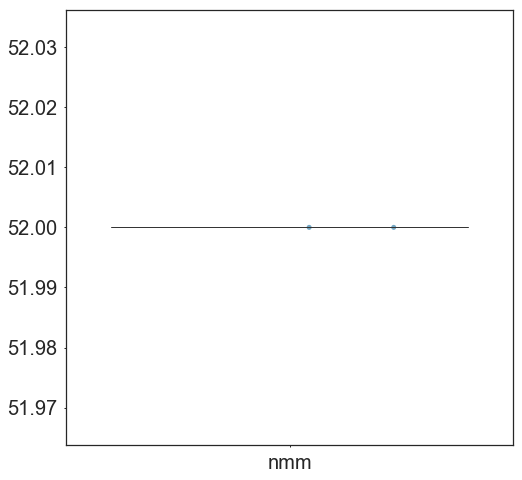

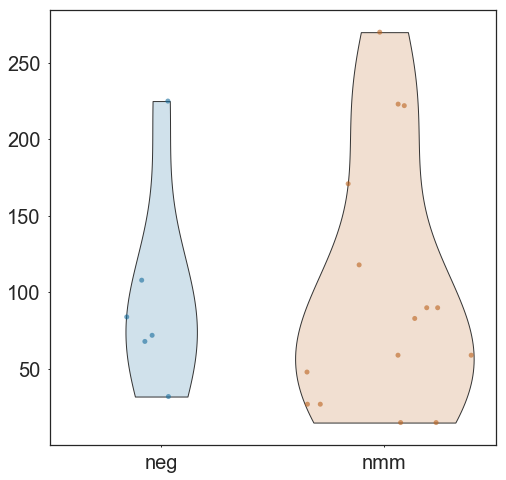

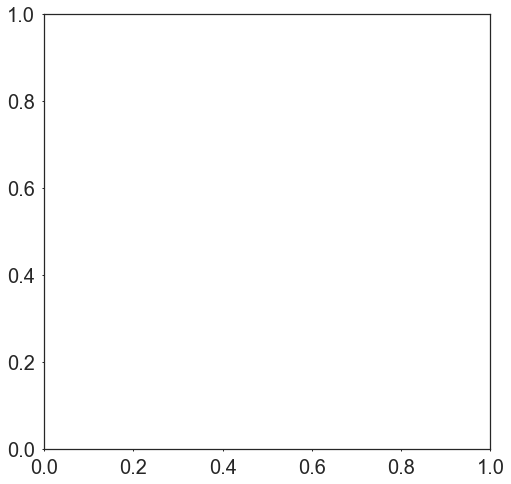

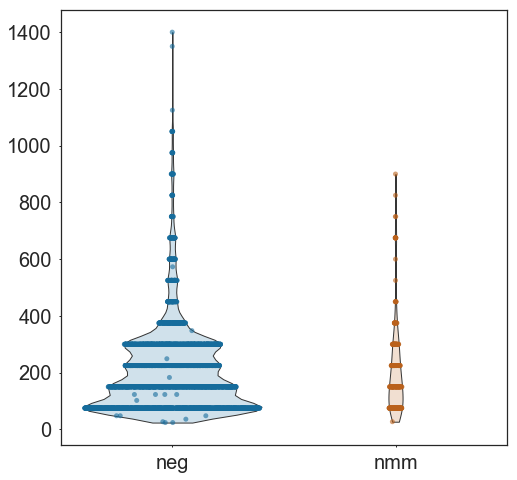

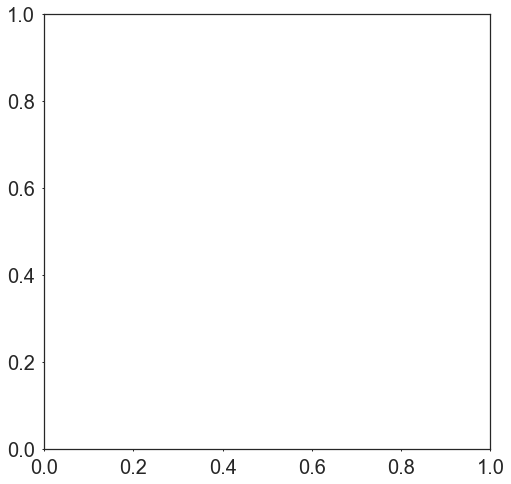

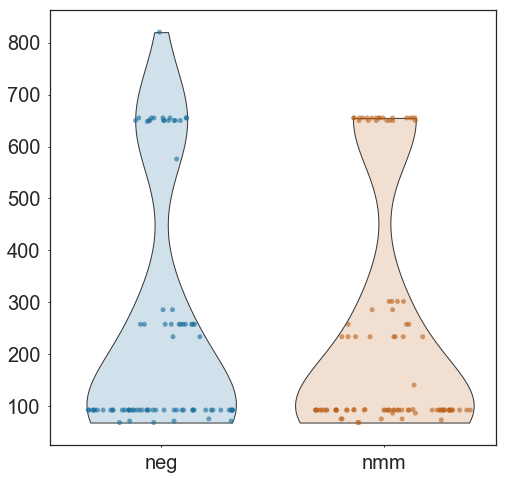

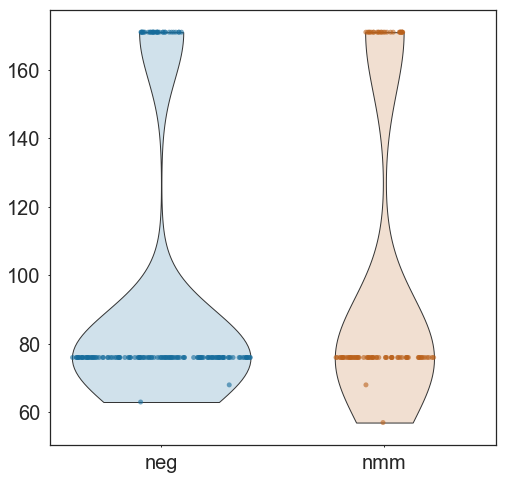

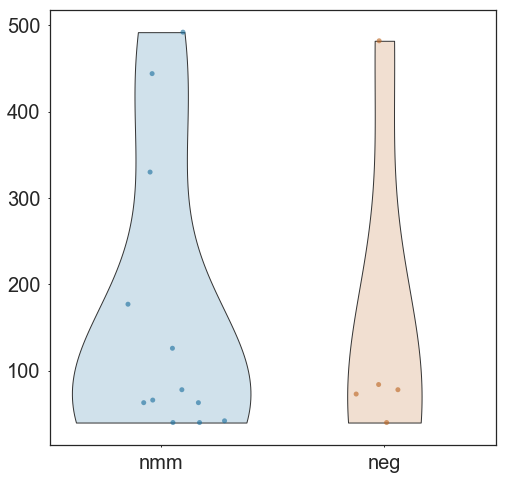

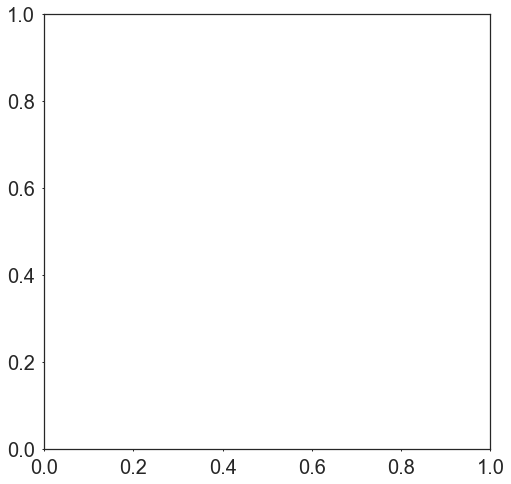

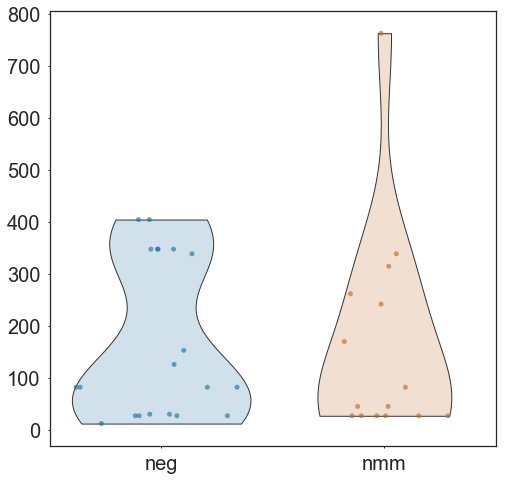

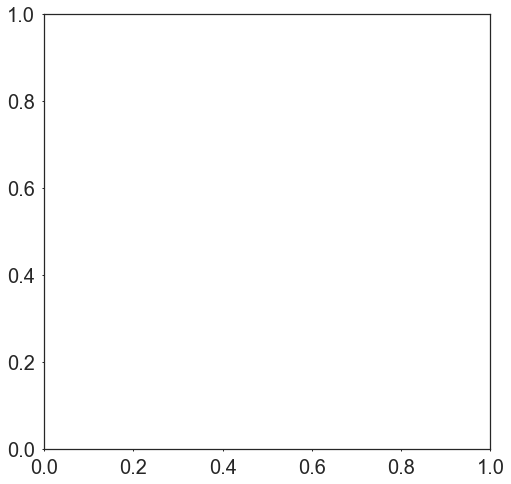

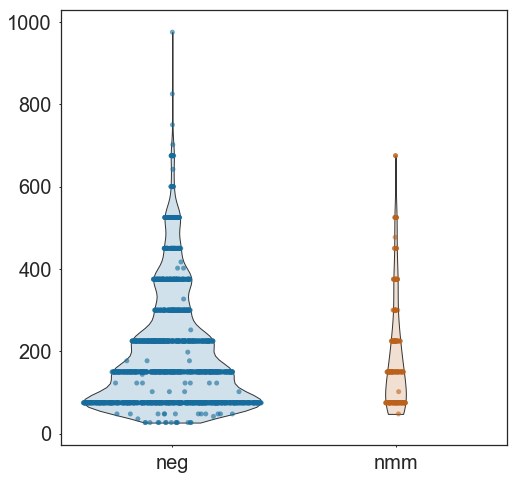

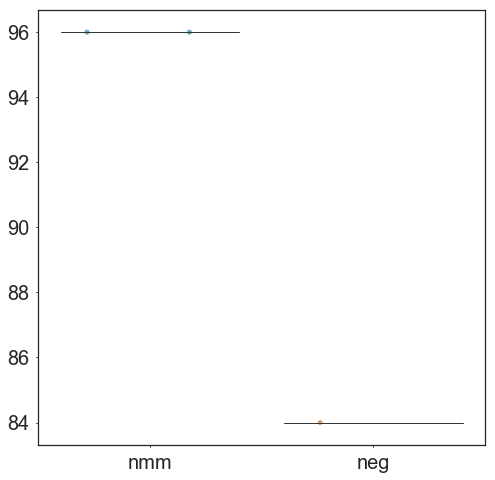

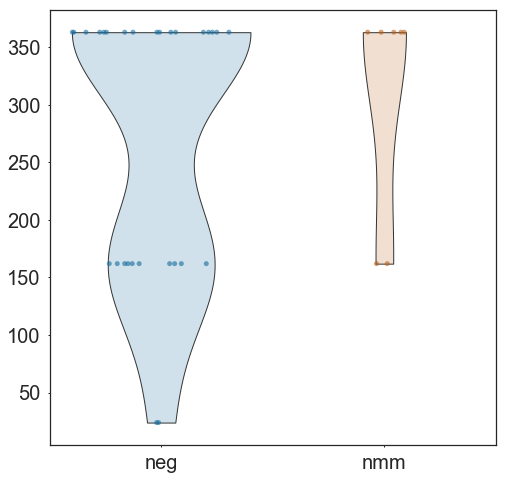

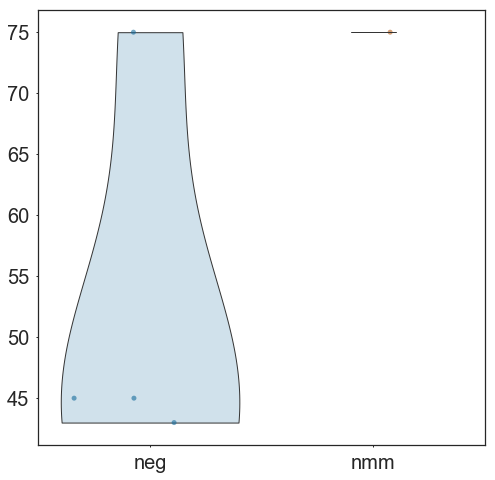

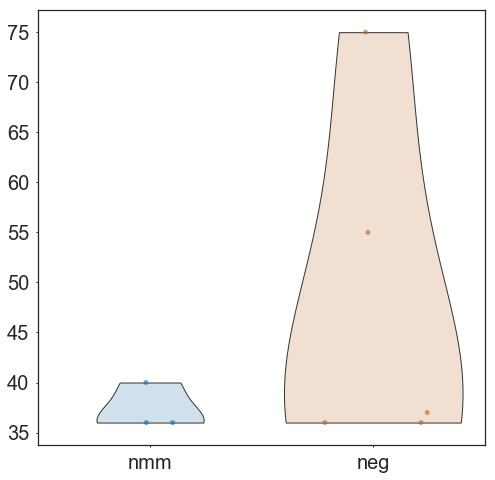

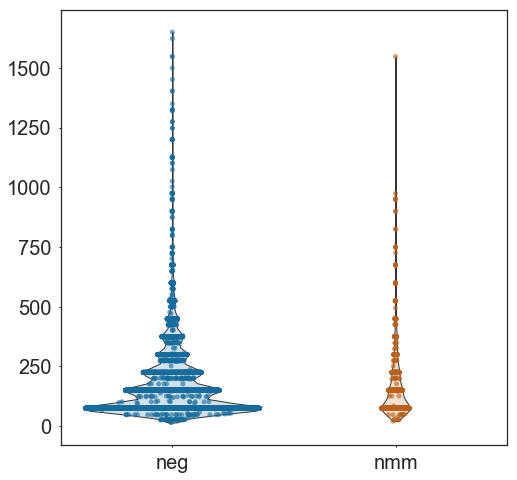

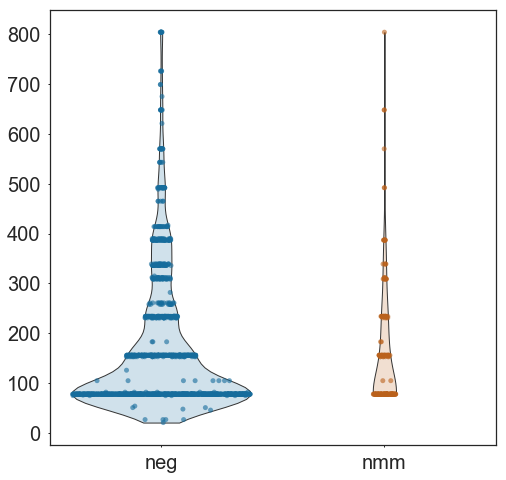

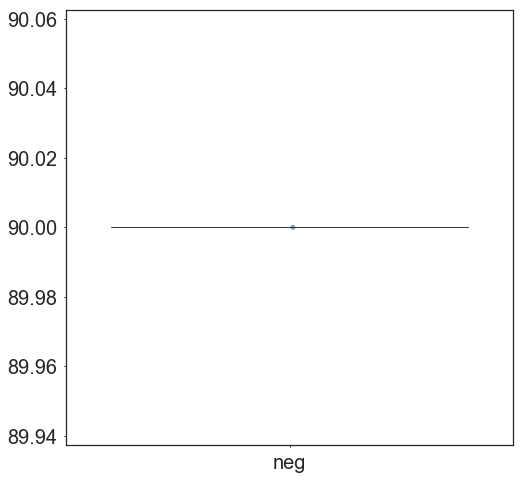

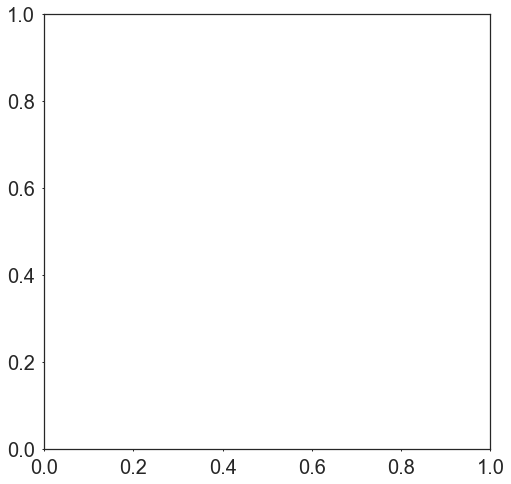

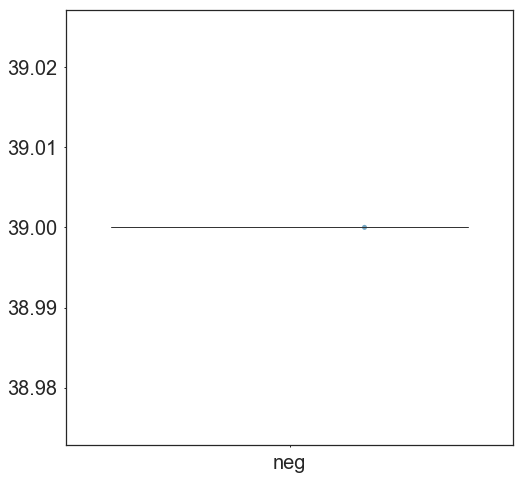

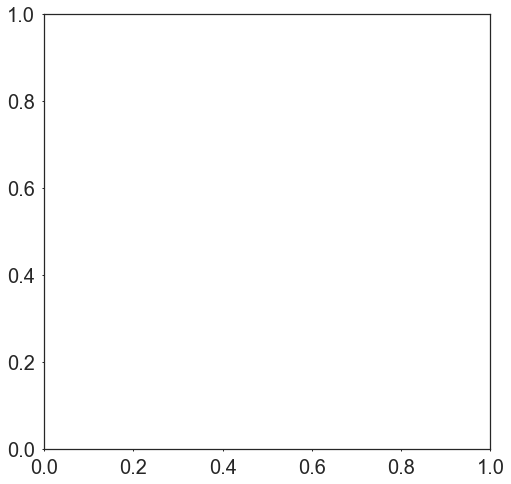

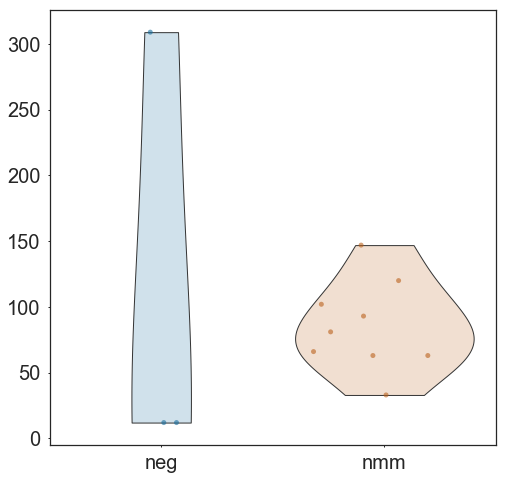

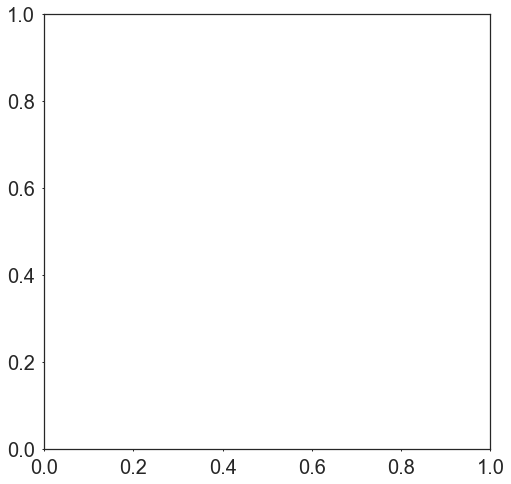

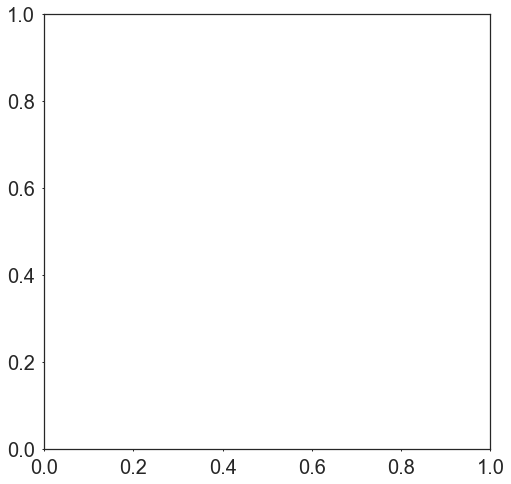

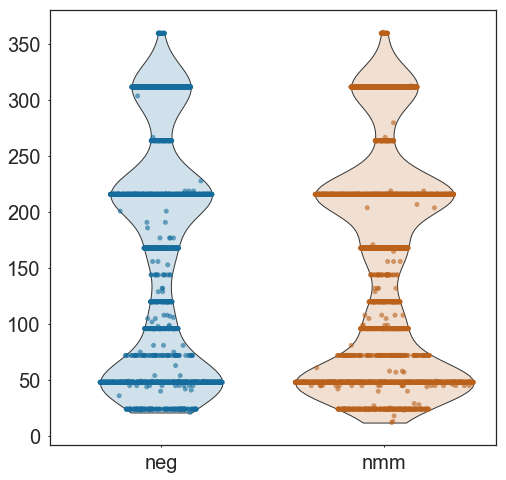

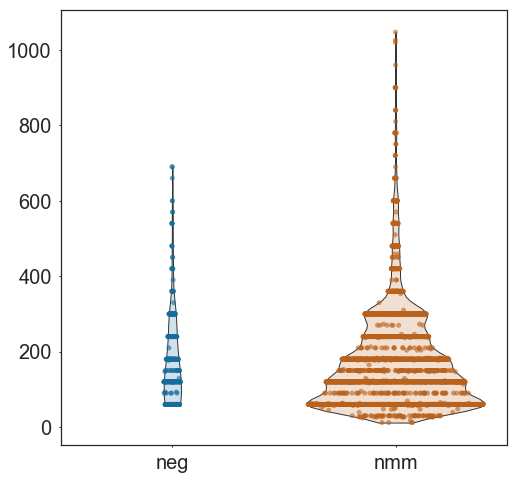

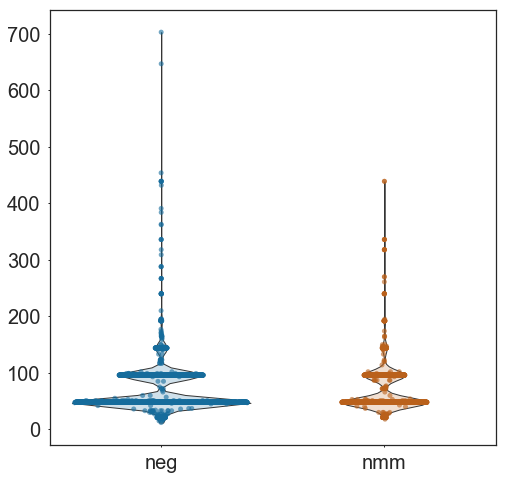

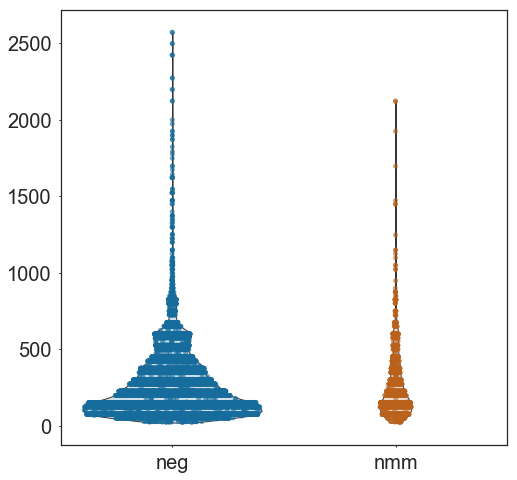

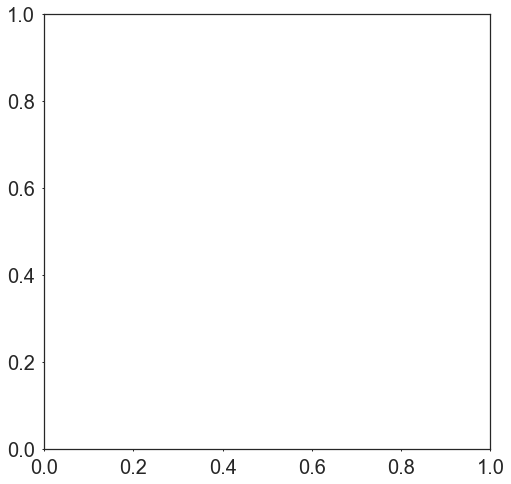

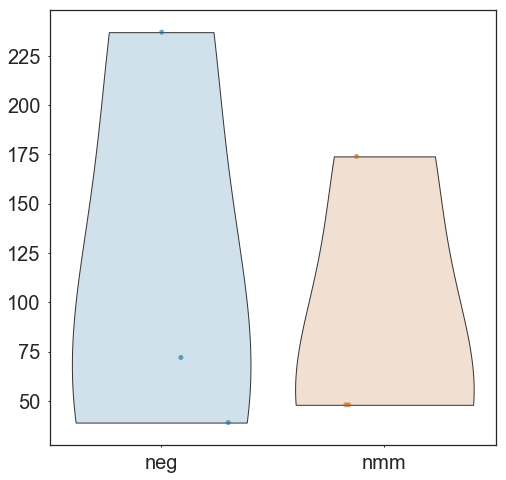

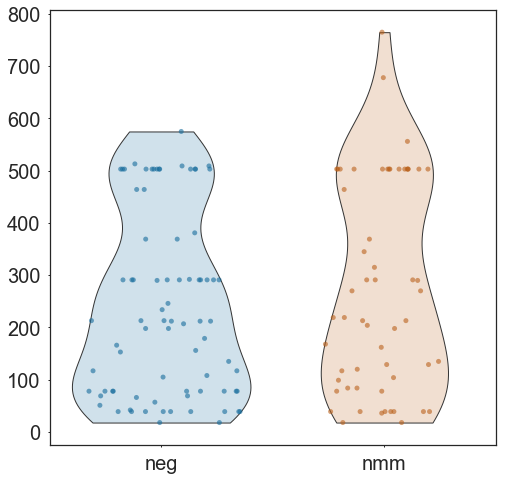

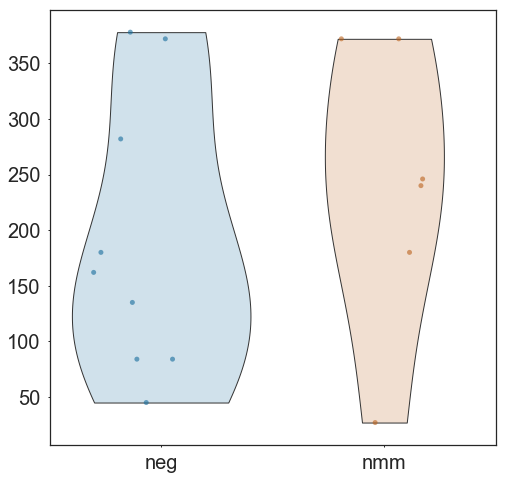

In [204]:
for gene in extensin_exitron_spliced_sizes:
    lengths = extensin_exitron_spliced_sizes[gene]
    labels = np.concatenate([np.repeat(samples[i].split('_')[0], len(x))
                             for i, x in enumerate(lengths)])
    lengths = np.concatenate(lengths)
    try:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax = snplt.sinaplot(
            x=labels, y=lengths,
            inner=None,
            violin_facealpha=0.2,
            point_facealpha=0.6,
            cut=0,
            point_edgecolor='none')
        plt.show()
    except ValueError:
        pass

In [81]:
percentage_spliced_long = extensin_exitron_percentages.loc[
    :, extensin_exitron_percentages.columns.str.startswith('percentage_exitronic')
].stack().reset_index()
percentage_spliced_long.columns = ['gene_id', 'sample', 'percent_spliced']
percentage_spliced_long[['cond', 'sample']] = (percentage_spliced_long['sample']
                                                   .str.replace('percentage_exitronic_', '')
                                                   .str.split('_', expand=True))
percentage_spliced_long.head()

,gene_id,sample,percent_spliced,cond
0,AT3G53330,1,0.0,neg
1,AT3G53330,1,0.0,nmm
2,AT3G53330,2,0.0,neg
3,AT3G53330,2,0.0,nmm
4,AT3G53330,3,0.0,neg


In [82]:
total_mapped_long = extensin_exitron_percentages.loc[
    :, extensin_exitron_percentages.columns.str.startswith('total_mapped_')
].stack().reset_index()
total_mapped_long.columns = ['gene_id', 'sample', 'total']
total_mapped_long[['cond', 'sample']] = (total_mapped_long['sample']
                                             .str.replace('total_mapped_', '')
                                             .str.split('_', expand=True))
percentage_spliced_long = percentage_spliced_long.merge(
    total_mapped_long, on=['gene_id', 'sample', 'cond']
)
percentage_spliced_long.head()

,gene_id,sample,percent_spliced,cond,total
0,AT3G53330,1,0.0,neg,0
1,AT3G53330,1,0.0,nmm,2
2,AT3G53330,2,0.0,neg,0
3,AT3G53330,2,0.0,nmm,0
4,AT3G53330,3,0.0,neg,0


In [83]:
gene_symbol_mapping = (
    ext_table[['AGI Identifier', 'gene_symbol']].set_index('AGI Identifier')
                                                .to_dict()['gene_symbol']
)
percentage_spliced_long['gene_symbol'] = percentage_spliced_long.gene_id.map(
    gene_symbol_mapping)

In [107]:
nmm_vs_cntrl = pd.read_csv(
    'nmm_rnaseq_differential_expression_05022018.tsv',
    sep='\t',
    index_col=0,
    usecols=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11]
)
nmm_vs_cntrl = nmm_vs_cntrl[
    ['A_NMM', 'A_Negative',
     'B_NMM', 'B_Negative',
     'C_NMM', 'C_Negative']
].stack().reset_index()
nmm_vs_cntrl.columns = ['gene_id', 'bio_sample', 'expression']
nmm_vs_cntrl.bio_sample = (nmm_vs_cntrl
                             .bio_sample
                             .str.split('_', expand=True)[1]
                             .map({'NMM': 'DMSO',
                                   'Negative': 'NMM'}))
nmm_vs_cntrl['gene_symbol'] = nmm_vs_cntrl.gene_id.map(
    gene_symbol_mapping)
nmm_vs_cntrl.head()

,gene_id,bio_sample,expression,gene_symbol
0,AT1G01010,DMSO,5.199620,NaN
1,AT1G01010,NMM,6.059700,NaN
2,AT1G01010,DMSO,5.237143,NaN
3,AT1G01010,NMM,6.032748,NaN
4,AT1G01010,DMSO,5.312551,NaN


In [138]:
order = (percentage_spliced_long[['gene_symbol', 'percent_spliced', 'total']]
             .groupby('gene_symbol')
             .mean()
             .reset_index()
             .sort_values('percent_spliced', ascending=False))
order = order[(order.total > 100) & (order.percent_spliced > 5)].gene_symbol
order = order[order.isin(nmm_vs_cntrl.gene_symbol)]

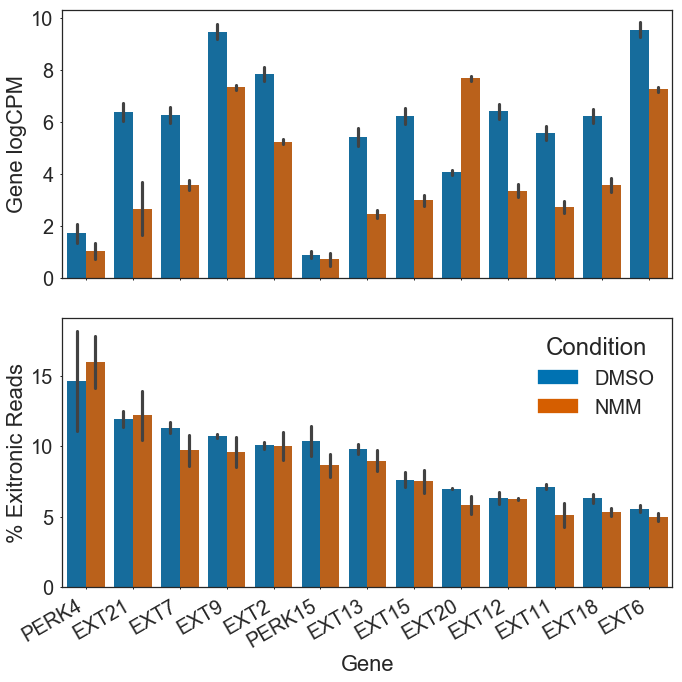

In [139]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, sharex=True)
sns.barplot(x='gene_symbol',
            hue='bio_sample',
            y='expression',
            data=nmm_vs_cntrl,
            order=order,
            ci='sd',
            ax=ax[0])
ax[0].legend_.remove()
ax[0].set_xticklabels([])
ax[0].set_xlabel('')
ax[0].set_ylabel('Gene logCPM')
sns.barplot(x='gene_symbol',
            hue='cond',
            y='percent_spliced',
            data=percentage_spliced_long,
            order=order,
            ci='sd',
            ax=ax[1])
ax[1].legend_.remove()
dummy_boxes = [
    Patch(color=pal[0], label='DMSO'),
    Patch(color=pal[1], label='NMM')
]
ax[1].legend(handles=dummy_boxes, title='Condition')
plt.setp(ax[1].get_xticklabels(), rotation=30, ha='right')
ax[1].set_xlabel('Gene')
ax[1].set_ylabel('% Exitronic Reads')
plt.tight_layout()
#plt.savefig('extensin_exitronic_percentage.svg')
plt.show()